# Board game machine learning analysis

* Description
* Dataset
* Goal
* General imports
* Scikit imports
* Data exploration & cleaning
    * Exploring the data using k-means clustering
* Predicting the average_rating (without splitting into test and train datasets)
* Predicting the average_rating using Holdout validation
* Predicting the average_rating using Kfold validation
* Predicting using different categories of independent variables


## Description

Board games have been making a comeback lately, and deeper, more strategic boardgames, like Settlers of Catan have become hugely popular. A popular site where these types of board games are discussed and reviewed is BoardGameGeek. The dataset for this project contains 80000 board games and their associated review scores. The data was scraped from BoardGameGeek and compiled into CSV format by Sean Beck.

This project was done as a part of my datascience learning on 
www.dataquest.io

## Dataset 

The dataset can be found here - 
https://github.com/ThaWeatherman/scrapers/blob/master/boardgamegeek/games.csv

Some of the column descriptions are - 

name -- name of the board game.

playingtime -- the playing time (given by the manufacturer).

minplaytime -- the minimum playing time (given by the manufacturer).

maxplaytime -- the maximum playing time (given by the manufacturer).

minage -- the minimum recommended age to play.

users_rated -- the number of users who rated the game.

average_rating -- the average rating given to the game by users. (0-10)

total_weights -- Number of weights given by users. Weight is a subjective measure that is made up by BoardGameGeek. It's how "deep" or involved a game is. Here's a full explanation.

average_weight -- the average of all the subjective weights (0-5).


## Goal

One interesting machine learning task for this dataset is to predict the average_rating using the other columns using various regression techniques and to measure the related errors

## General imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Scikit imports

In [2]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

## Data exploration & cleaning

Reading in the data

In [3]:
board_games = pd.read_csv("games.csv")
board_games.head()

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943


Checking the datatypes of all the columns

In [4]:
board_games.dtypes

id                        int64
type                     object
name                     object
yearpublished           float64
minplayers              float64
maxplayers              float64
playingtime             float64
minplaytime             float64
maxplaytime             float64
minage                  float64
users_rated               int64
average_rating          float64
bayes_average_rating    float64
total_owners              int64
total_traders             int64
total_wanters             int64
total_wishers             int64
total_comments            int64
total_weights             int64
average_weight          float64
dtype: object

Removing all the null rows. Also, checking the before and after length of the dataset

In [5]:
print("---Length of the dataset before dropping null rows---\n")
print(len(board_games))

# dropping null values
board_games.dropna(axis=0,inplace=True)

print("\n---Length of the dataset after dropping null rows---\n")
print(len(board_games))

---Length of the dataset before dropping null rows---

81312

---Length of the dataset after dropping null rows---

81268


Also dropping the rows that have users_rated value put to 0 since that means these games have no reviews

In [6]:
board_games = board_games[board_games["users_rated"] != 0]
print("---Length of the dataset after dropping games with no reviews---\n")
print(len(board_games))

---Length of the dataset after dropping games with no reviews---

56894


Plotting a histogram of the average_rating column 

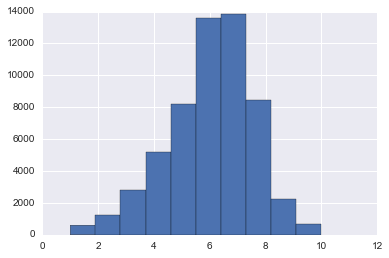

In [7]:
board_games["average_rating"].hist()

Printing out the mean and the standard deviation of the average_rating column

In [8]:
print("---Mean average rating---\n")
print(np.mean(board_games["average_rating"]))

print("\n---Standard deviation of the average rating---\n")
print(np.std(board_games["average_rating"]))

---Mean average rating---

6.016112849333889

---Standard deviation of the average rating---

1.5788160595839211


### Exploring the data using K-means clustering

In [9]:
# initiating the model with 5 clusters
kmeans_model = KMeans(n_clusters=5, random_state=1)

# singling out all the numeric columns in the dataset
numeric_columns = board_games.iloc[:,3:]
numeric_columns.head()

# fitting the model over these columns
kmeans_model.fit(numeric_columns)

# extracting the labels 
labels = kmeans_model.labels_

Now to plot the cluster map, we are going to calculate the mean and the standard deviation of each row in the dataset

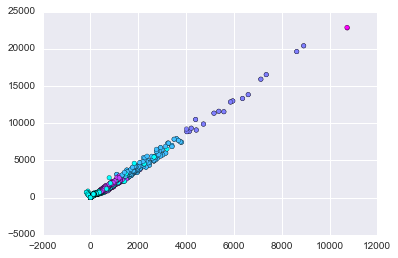

In [10]:
game_mean = numeric_columns.apply(np.mean,axis=1)
game_std = numeric_columns.apply(np.std,axis=1)

# plotting the map
plt.scatter(game_mean,game_std,c=labels,cmap='cool')
plt.show()

As we can see from the cluster diagrame, we can see that most of the games are clustered at a small space. This could mean that they are mostly similar in key statistics like owners, wanters, ratings, wishers etc which hint at the popularity of the game.

As the values increase (which means as the games become higher in ratings and the number of users), we can see that there are fewer and fewer such games. Majority of the games don't have as many users

## Predicting the average_rating (without splitting into test and train datasets)

In [11]:
# exploring the correlation that the "average_rating" column has with other columns
numeric_columns.corr()["average_rating"]

yearpublished           0.108461
minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
Name: average_rating, dtype: float64

The columns that seem to have a decently high correlation with the average rating are - 

1) year published -> positive correlation. More recent the game, more average rating it seems to carry

2) minage -> positive correlation. Higher the minimum age, higher it seems to be rated

3) users_rated -> this seems to be an obvious correlation

4) total_owners, total_traders, total_wanters, total_wishers, total_comments -> all seem to be have an obvious correlation with the average rating

5) average_weight -> positive correlation -> the more involved the game is, the higher it seems to be rated

6) Bayes average weight -> this has a high correlation. This also seems to be derived from the average rating. It could cause overfitting

In [12]:
# initializing the linear regression
reg = LinearRegression()

# removing the average rating the bayes average rating columns
col = list(numeric_columns.columns)
col.remove('average_rating')
col.remove('bayes_average_rating')

# fitting the regression model
reg.fit(board_games[col],board_games["average_rating"])

# making the predictions
predictions = reg.predict(board_games[col])

# calculating the error
error = mean_squared_error(board_games["average_rating"],predictions)
print(error)

2.09339697583


The error rate is close to the standard deviation of all board game ratings. This indicates that our model may not have high predictive power. We'll need to dig more into which games were scored well, and which ones weren't.

We can now use the Hold out validation technique to bifurcate the data into test and train datasets and see if the error metric shows any improvement

## Predicting the average_rating using Holdout validation

In [13]:
# holdout validation with 80% of the data being training data and 20% being testing data

# shuffling the indices
rand_ind = np.random.permutation(board_games.index)
shuffled_board = board_games.loc[rand_ind]

train = shuffled_board.iloc[0:45515]
test = shuffled_board.iloc[45515:]

# initializing the linear regression
reg_hold = LinearRegression()

# training it on the train dataset
reg_hold.fit(train[col],train["average_rating"])

# making predictions on the test dataset
predictions_hold = reg_hold.predict(test[col])

# calculating the mean squared error 
error_hold = mean_squared_error(test["average_rating"],predictions_hold)
print(error_hold)

2.11029494979


We can see that there is no major improvement over the previous value of 2.0933

## Predicting the average_rating using Kfold validation

In [14]:
kf = KFold(n=len(board_games),n_folds=7,shuffle=True,random_state=8)
lr = LinearRegression()

# calculating the mean squared error
# cross_val_score(estimator, X, Y, scoring=None, cv=None)
mse_kf = cross_val_score(lr,board_games[col],board_games["average_rating"],scoring="mean_squared_error",cv=kf)

print(mse_kf)

# calculating the average mean squared error
average_mse = np.average(mse_kf)
print(average_mse)

[-2.01643297 -2.1584996  -2.10210855 -2.07507699 -2.09181026 -2.14662555
 -2.07565563]
-2.09517279353


As we can see, there is still not major improvement in the average rating value using the kfold validation technique.

If you are wondering why the mse came out to be negative, click the below link - 
http://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-error

## Predicting using different categories of independent variables

we can explore the effect of different categories of independent variables like playing time, number of players, number of total users etc.

In [15]:
playing_time = ["minplaytime","maxplaytime"]
players = ["minplayers","maxplayers"]
users = ["users_rated"]

mse_kf_playtime = cross_val_score(lr,board_games[playing_time],board_games["average_rating"],scoring="mean_squared_error",
                                  cv=kf)
mse_kf_players = cross_val_score(lr,board_games[players],board_games["average_rating"],scoring="mean_squared_error",
                                 cv=kf)
mse_users= cross_val_score(lr,board_games[users],board_games["average_rating"],scoring="mean_squared_error",
                                  cv=kf)


average_mse_playtime = -1 * np.average(mse_kf_playtime)
average_mse_players = -1 * np.average(mse_kf_players)
average_mse_users = -1 * np.average(mse_users)

print("---Mean square error by playing time---\n")
print(average_mse_playtime)
print("\n---Mean square error by number of players allowed in the game---\n")
print(average_mse_players)
print("\n---Mean square error by number of users who rated the game---\n")
print(average_mse_users)

---Mean square error by playing time---

2.49134443352

---Mean square error by number of players allowed in the game---

2.49049271447

---Mean square error by number of users who rated the game---

2.46131499111


## Predicting using ridge regression instead of linear regression

In [ ]:
rid = Ridge(alpha=1.0)
rid.fit(board_games[col],board_games["average_rating"])
predictions_rid = rid.predict(board_games[col])
error_rid = mean_squared_error(board_games["average_rating"],predictions_rid)
print(error_rid)